In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Configs

In [2]:
tf.random.set_seed(96)

dataset_path = "MicrosoftStock.csv"
train_test_split = 0.9
window_size = 10
batch_size = 32
epochs = 25

## Import Dataset

In [3]:
df = pd.read_csv(dataset_path)
df.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [4]:
df.isna().sum()

index     0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [5]:
df['date'] = pd.to_datetime(df['date'])

## Graphs and Correlation Matrix

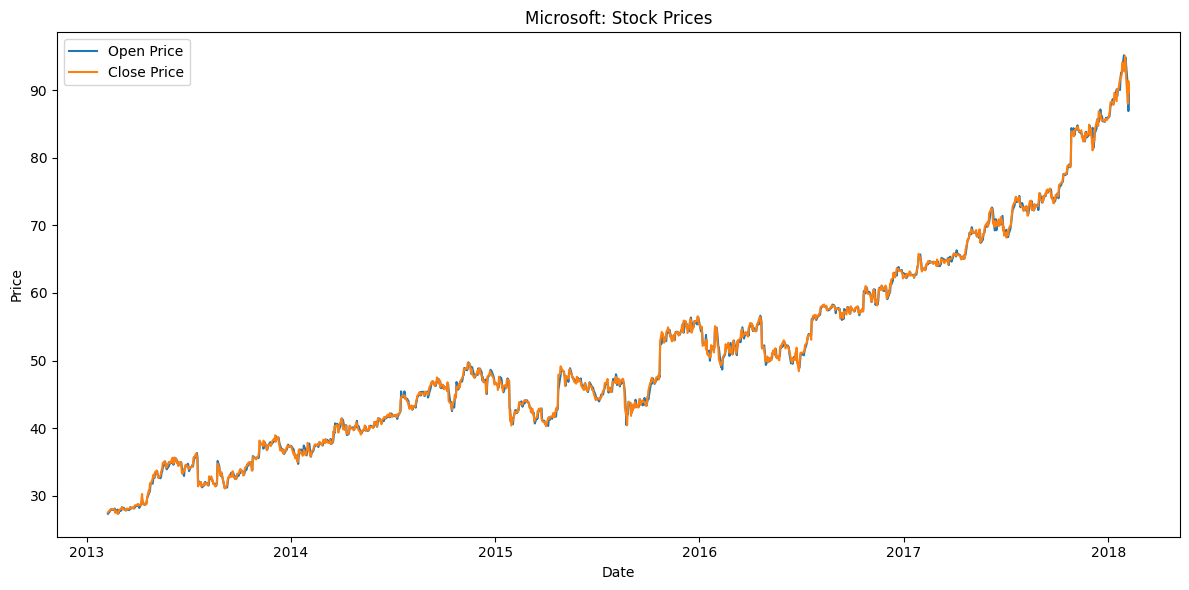

In [6]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft: Stock Prices')
plt.plot(df['date'], df['open'], label='Open Price')
plt.plot(df['date'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

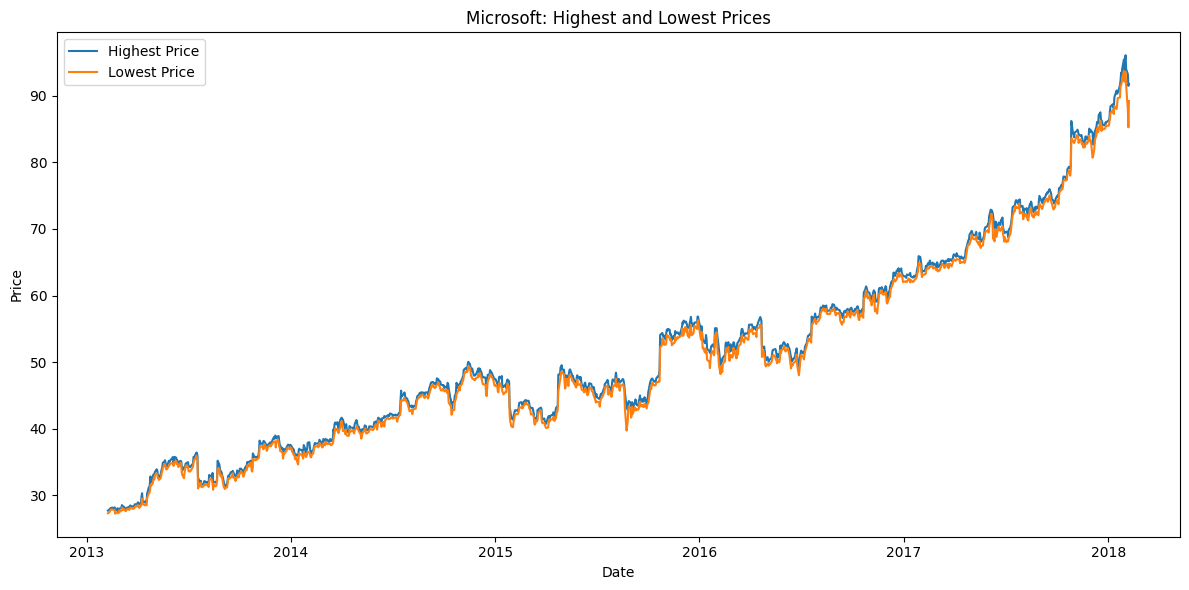

In [7]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft: Highest and Lowest Prices')
plt.plot(df['date'], df['high'], label='Highest Price')
plt.plot(df['date'], df['low'], label='Lowest Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

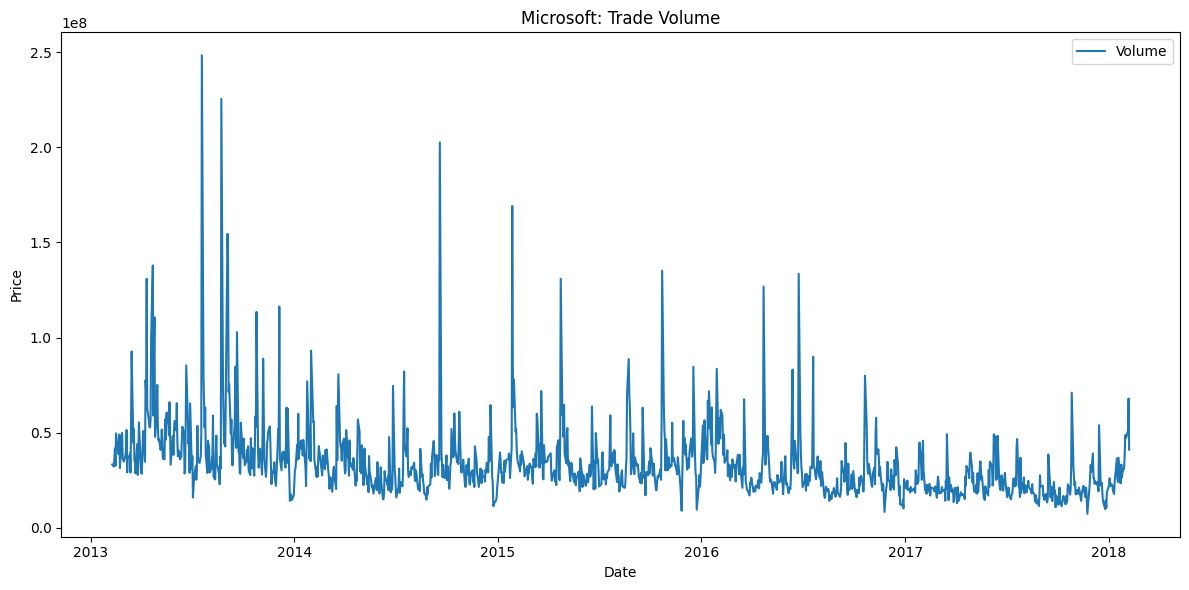

In [8]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft: Trade Volume')
plt.plot(df['date'], df['volume'], label='Volume')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df.head()

,index,open,high,low,close,volume
0,390198,27.35,27.71,27.31,27.55,33318306
1,390199,27.65,27.92,27.50,27.86,32247549
2,390200,27.88,28.00,27.75,27.88,35990829
3,390201,27.93,28.11,27.88,28.03,41715530
4,390202,27.92,28.06,27.87,28.04,32663174


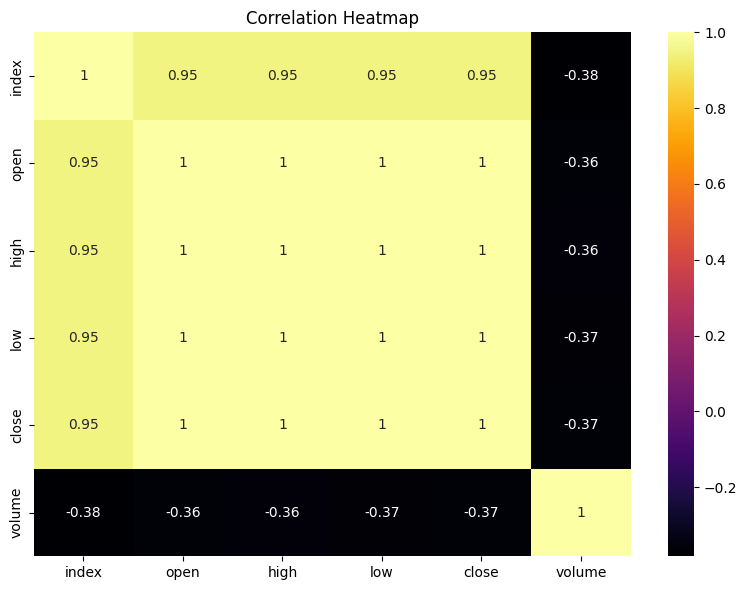

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='inferno')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [11]:
df['date'] = pd.to_datetime(df['date'])
df.drop('Name', inplace=True, axis=1)
df.head()

,index,date,open,high,low,close,volume
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174


## Scale Data

In [12]:
stock_close = df['close'].values

In [13]:
training_data_len = int(np.ceil(train_test_split * len(stock_close)))

dataset = stock_close.reshape(-1, 1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_train = scaled_data[:training_data_len]

In [14]:
scaled_train.shape

(1134, 1)

## Provide Context to train LSTM

In [15]:
def create_sliding_window(data, window_size):
    X, y = [], []
    
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    
    return np.array(X), np.array(y).reshape(-1)

In [16]:
X_train, y_train = create_sliding_window(scaled_train, window_size)

In [17]:
X_train.shape, y_train.shape

((1124, 10, 1), (1124,))

## Build Model

In [18]:
model = Sequential(name="StockPriceLSTM")
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mae", metrics=["root_mean_squared_error"])

Model: "StockPriceLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4142 - root_mean_squared_error: 0.5403
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1338 - root_mean_squared_error: 0.1881
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1172 - root_mean_squared_error: 0.1556
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1122 - root_mean_squared_error: 0.1494
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1082 - root_mean_squared_error: 0.1470
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1130 - root_mean_squared_error: 0.1543
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0990 - root_mean_squared_error: 0.1339
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1034 - root_mean_squared_error: 0.1403
Epoch 9/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1006 - root_mean_squared_error: 0.1387
Epoch 10/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1027 - root_mean_squared_error: 0.1366
Epoch 11/

In [20]:
def generate_history_graph(history):
    metrics = list(history.history.keys())
    num_metrics = len(metrics)
    
    plt.figure(figsize=(8*num_metrics, 6))
    
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, idx)
        plt.plot(history.history[metric], label=metric)
        plt.title(f"{metric} over Epochs")
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

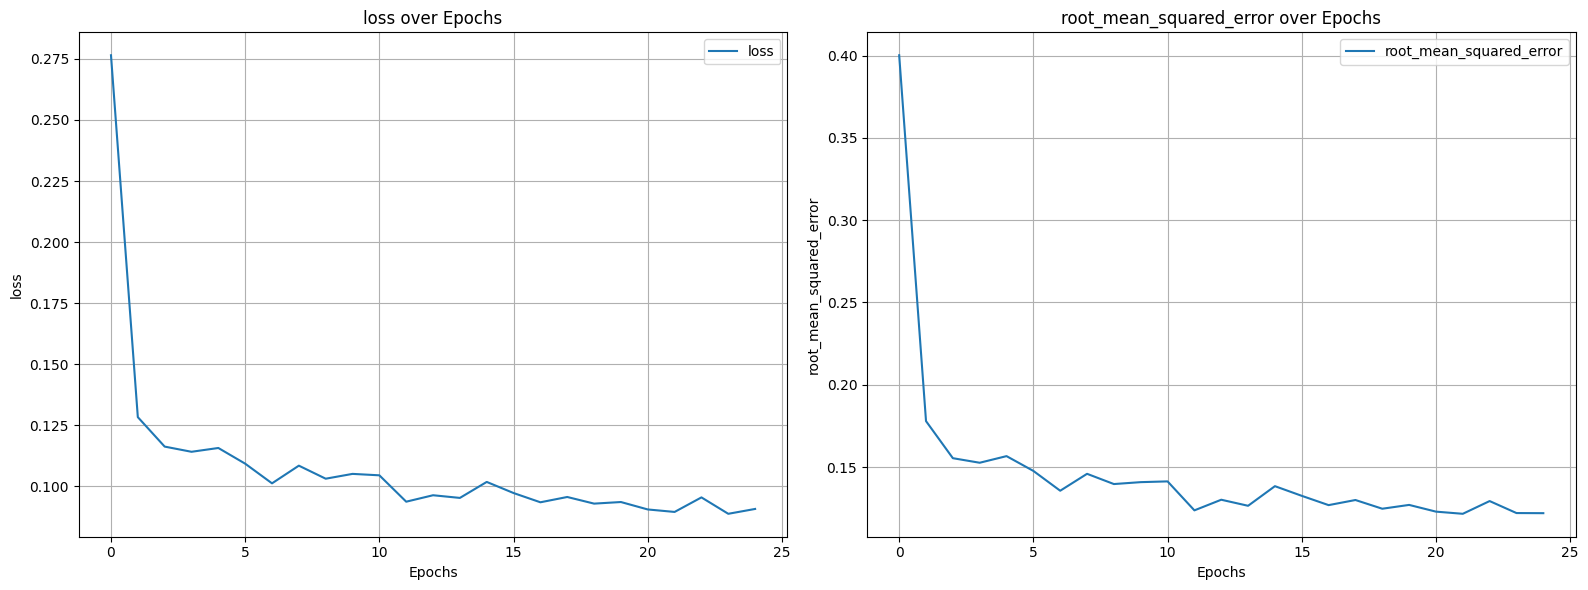

In [21]:
generate_history_graph(history)

In [24]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
model.save("StockPriceLSTM.keras")

In [25]:
test_data = scaled_data[training_data_len - 60:]
X_test = []

X_test, _ = create_sliding_window(test_data, 60)

In [26]:
len(test_data), X_test.shape

(185, (125, 60, 1))

In [27]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


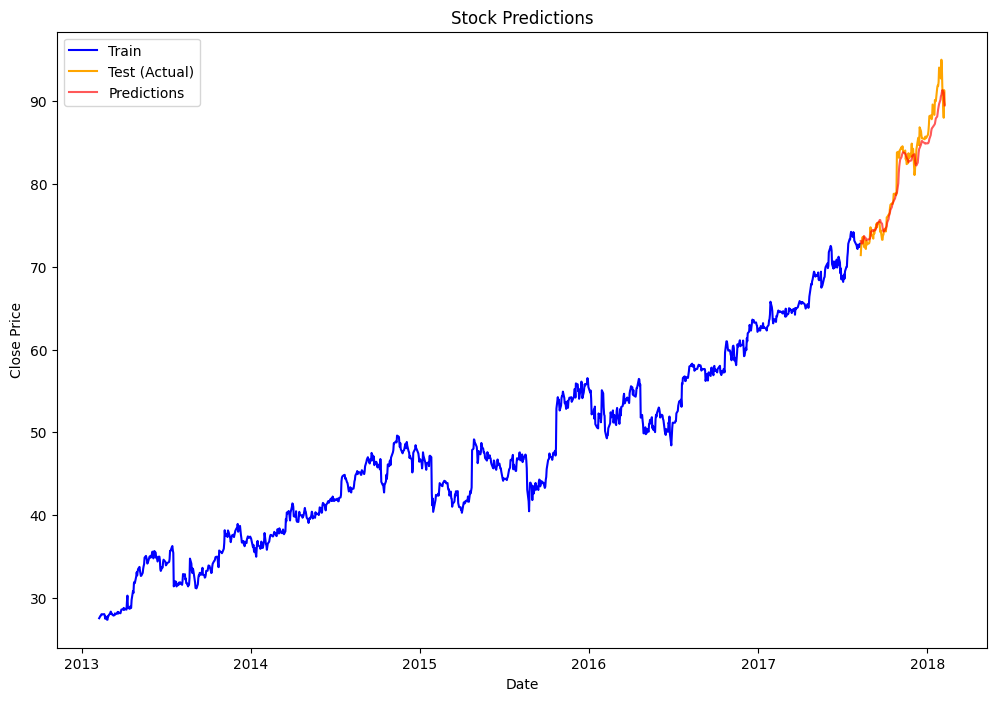

In [31]:
train = df[:training_data_len]
test =  df[training_data_len:].copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red', alpha=0.65)
plt.title("Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()